# Sentiment Analysis - Model Development

## On Regular Feature-Engineered Data

### 1. CV+TF-IDF

In [52]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [53]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [55]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=42)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5, random_state=42)

In [56]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


#### 1.1 Logistic Regression Model

##### 1.1.1 Initialize and training the Model

In [57]:
# Model 1: basic LR (<5s)

# init and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and train the model with L1 regularization (Lasso)
LR = LogisticRegression(random_state=42)  # C is the inverse of regularization strength
LR.fit(X_train, y_train)

# Predict on the test set
LR_y_train_pred = LR.predict(X_train)

# Evaluate the model
LR_train_accuracy_pretuned = accuracy_score(y_train, LR_y_train_pred)
print("Training (Pre-tuned) Accuracy with LR: {}".format(LR_train_accuracy_pretuned))

Training (Pre-tuned) Accuracy with LR: 0.5354938271604939


##### 1.1.2 Model Hyperparameter Tuning

In [58]:
# Hyperparameter with randomized search CV (7 mins)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Define Pipeline
LR_pipeline = Pipeline([
    # Variable Selection and Hyperparameter Tuning
    # ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classifier', LogisticRegression(random_state=42))
])

# # Define param distributions for pipeline only
# LR_pipeline_param_distributions = {
#     'classifier__penalty': ['l1', 'l2', 'elasticnet'],
#     'classifier__C': uniform(loc=0.01, scale=0.99),  # Uniform distribution between 0.01 and 1
#     'classifier__tol': uniform(loc=1e-3, scale=0.099),  # Uniform distribution between 0.001 and 0.1
#     'classifier__max_iter': [500, 1000, 5000],  # Fixed choices
#     'classifier__solver': ['saga'],
#     'classifier__l1_ratio': uniform(loc=0, scale=1)  # Uniform distribution between 0 and 1 for ElasticNet
# }

# Perform Randomized Search CV (10: 2 min or 50: 16 mins)
# LR_random_search = RandomizedSearchCV(LR_pipeline, LR_pipeline_param_distributions, n_iter=50, cv=5, random_state=42)


# Define parameter grid
LR_pipeline_param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.01, 0.1, 0.5, 1, 5, 10],
    'classifier__tol': [0.001, 0.01, 0.1],
    'classifier__max_iter': [500, 1000, 5000],
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Only relevant for 'elasticnet'
}

# Perform Grid Search CV
LR_grid_search = GridSearchCV(LR_pipeline, LR_pipeline_param_grid, cv=5, verbose=1)

LR_grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'classifier__max_iter': [500, 1000, 5000],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                         'classifier__tol': [0.001, 0.01, 0.1]},
             verbose=1)

In [59]:
# Retrieve the best estimator after random search CV is fitted
best_LR_estimator = LR_grid_search.best_estimator_

LR_val_accuracy = LR_grid_search.best_score_
print("Validation accuracy from Randomized Search CV: {}".format(LR_val_accuracy))

# Access the coefficients of the Logistic Regression model
lr_coefficients = best_LR_estimator.named_steps['classifier'].coef_[0]

# Identify the features with the highest absolute coefficients
top_indices = lr_coefficients.argsort()[-10:][::-1]  # Get indices of top 10 features
top_features = [X_val.columns[i] for i in top_indices]  # Get feature names from indices

# Extract the names of the top 10 features
print("Top 10 Most Important Features:")
for feature in top_features:
    print(feature)

Validation accuracy from Randomized Search CV: 0.537689393939394
Top 10 Most Important Features:
popularity
tempo
time_signature
energy
danceability
mode
loudness
explicit
speechiness
liveness


##### 1.1.3 Model Saving/ Loading

In [60]:
# Save tuned model and its best hyperparameters
import joblib

joblib.dump(LR_grid_search.best_estimator_, 'LR_model.pkl')
joblib.dump(LR_grid_search.best_params_,'LR_best_params.joblib')

['LR_best_params.joblib']

In [61]:
# # load the saved model (NOTE: uncomment only if needed)
# import joblib

# loaded_model=joblib.load('LR_model.pkl')
# loaded_model_best_params=joblib.load('LR_best_params.joblib')

##### 1.1.4 Model Predictions

In [62]:
# Refit the model with the best parameters
LR_pipeline.set_params(**LR_grid_search.best_params_,)
LR_pipeline.fit(X_train, y_train)


# Make predictions on the training set and calculate accuracy
LR_y_train_pred_tuned = LR_pipeline.predict(X_train)
LR_train_accuracy_posttuned = accuracy_score(y_train, LR_y_train_pred_tuned)
print("Training accuracy after tuning: {}".format(LR_train_accuracy_posttuned))

# Make predictions on the test set and calculate accuracy
LR_y_test_pred = LR_pipeline.predict(X_test)
LR_test_accuracy = accuracy_score(y_test, LR_y_test_pred)
print("Testing (Post-tuned) Accuracy from automated tuning on LR: {}".format(LR_test_accuracy))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Training accuracy after tuning: 0.5354938271604939
Testing (Post-tuned) Accuracy from automated tuning on LR: 0.5398773006134969


##### 1.1.5 Results Visualization

In [63]:
# Accuracy Comaprsion

print("Classification Accuracies for Linear Regression:")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(LR_train_accuracy_pretuned*100, LR_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(LR_train_accuracy_posttuned*100, LR_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(LR_val_accuracy*100, LR_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(LR_test_accuracy*100, LR_test_accuracy))

Classification Accuracies for Linear Regression:
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		53.55% 	(0.5354938271604939)
Training Accuracy (Post-tuned): 	53.55% 	(0.5354938271604939)

Validation Accuracy: 			53.77% 	(0.537689393939394)
Testing Accuracy: 			53.99% 	(0.5398773006134969)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        88
           1       0.00      0.00      0.00        75

    accuracy                           0.54       163
   macro avg       0.27      0.50      0.35       163
weighted avg       0.29      0.54      0.38       163



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

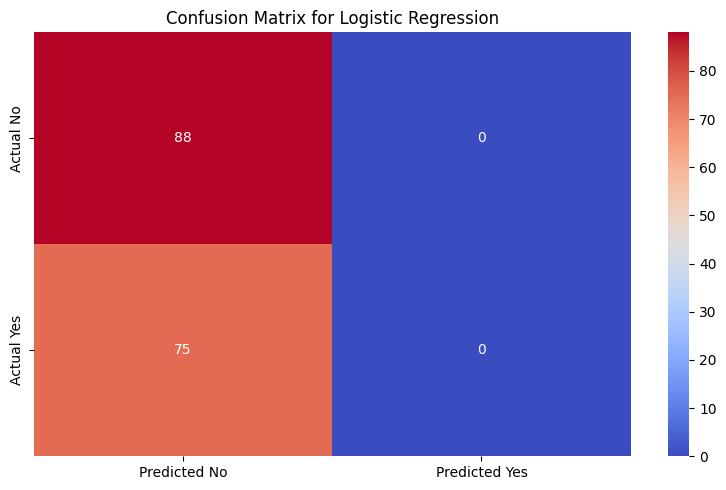

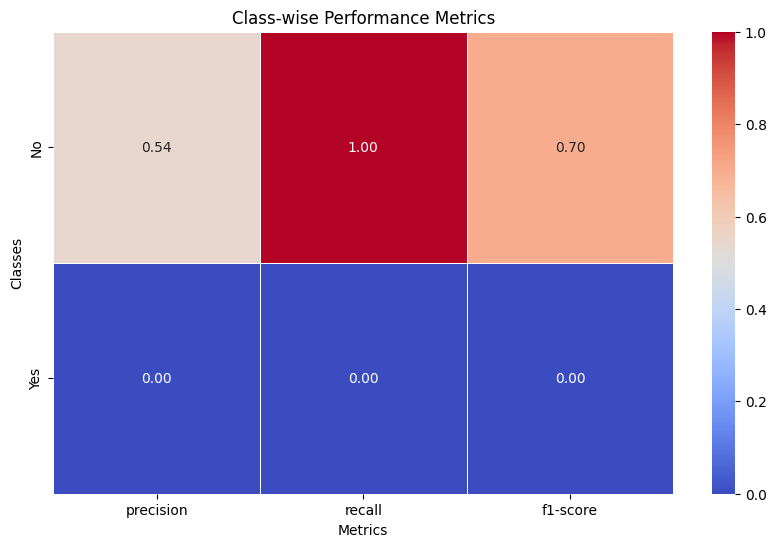

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Model Output
# Classification report
LR_classification_report=classification_report(y_test, LR_y_test_pred)
print(LR_classification_report)


# Confusion matrix with seaborn heatmap
LR_conf_matrix=confusion_matrix(y_test, LR_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(LR_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Logistic Regression')
plt.tight_layout()
plt.savefig("LR_confusion_matrix.png")


# Class-wise Performance Metrics
LR_classification_report_2 = classification_report(y_test, LR_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [LR_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("LR_performance_metrics.png")
plt.show()

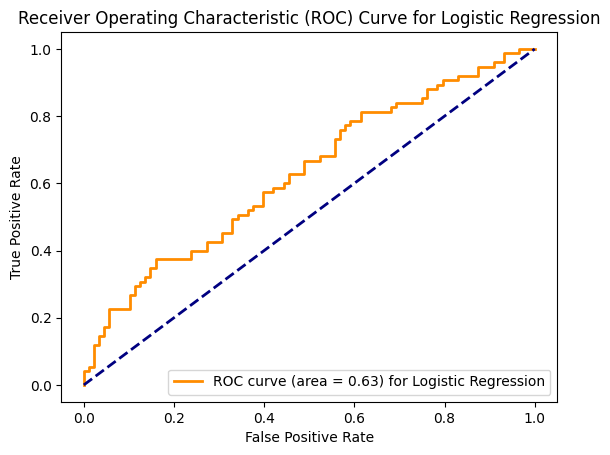

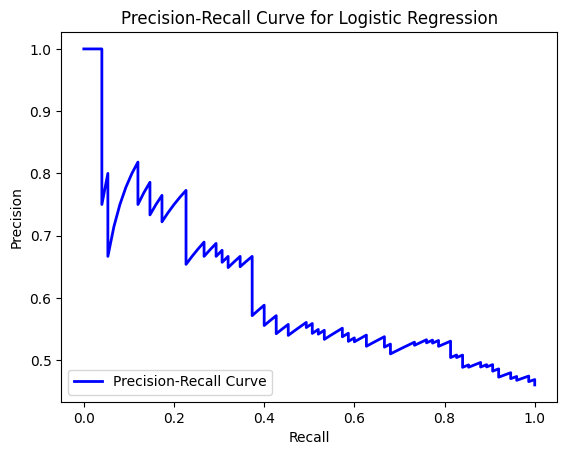

In [67]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
LR_y_scores=LR_pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, LR_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig("LR_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, LR_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc="lower left")
plt.savefig("LR_precision_recall_curve.png")
plt.show()

#### 1.2 Naive Bayes Model

##### 1.2.1 Initialize and training the Model

In [68]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [69]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# NOTE: ONLY for Naive Bayes
# Shifting loudness to ensure all positive values, NB doesn't allow it

df['loudness']=df['loudness']+60
df['loudness']

0       54.066
1       56.817
2       54.321
3       55.632
4       54.662
         ...  
1616    47.373
1617    55.386
1618    45.939
1619    49.720
1620    55.511
Name: loudness, Length: 1621, dtype: float64

In [71]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [72]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=42)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5, random_state=42)

In [73]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


In [75]:
# Model 2: Naive Bayes (<5s)

# init and training the model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize and train the model with L1 regularization (Lasso)
MNB = MultinomialNB()  # C is the inverse of regularization strength
MNB.fit(X_train, y_train)

# Predict on the train set
MNB_y_train_pred = MNB.predict(X_train)

# Evaluate the model
MNB_train_accuracy_pretuned = accuracy_score(y_train, MNB_y_train_pred)
print("Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: {}".format(MNB_train_accuracy_pretuned))

Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: 0.5848765432098766


##### 1.2.2 Model Hyperparameter Tuning

In [77]:
# Hyperparameter with randomized search CV (7 mins)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline
MNB_pipeline = Pipeline([
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes classifier
])

# Define parameter grid for GridSearchCV
MNB_pipeline_param_grid = {
    'classifier__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],  # Smoothing parameter
    'classifier__fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Perform Grid Search CV
MNB_grid_search = GridSearchCV(MNB_pipeline, MNB_pipeline_param_grid, cv=5, verbose=1)
MNB_grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0,
                                               10.0],
                         'classifier__fit_prior': [True, False]},
             verbose=1)

In [78]:
# Retrieve the best estimator after Grid Search CV is fitted
best_MNB_estimator = MNB_grid_search.best_estimator_

MNB_val_accuracy = MNB_grid_search.best_score_
print("Validation accuracy from Randomized Search CV: {}".format(MNB_val_accuracy))

# Assuming your feature names are stored in a list called 'feature_names'
MNB_feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Access the feature log probabilities
MNB_feature_log_probs = best_MNB_estimator.named_steps['classifier'].feature_log_prob_

# For a binary classification problem (two classes), you can look at the difference in log probabilities
# for the positive class (e.g., class 1) vs the negative class (e.g., class 0)
class_0_log_probs = MNB_feature_log_probs[0]
class_1_log_probs = MNB_feature_log_probs[1]

# Calculate the difference in log probabilities
MNB_log_prob_diff = class_1_log_probs - class_0_log_probs

# Identify the features with the highest absolute log probability differences
MNB_top_indices = MNB_log_prob_diff.argsort()[-10:][::-1]  # Get indices of top 10 features
MNB_top_features = [MNB_feature_names[i] for i in MNB_top_indices]  # Get feature names from indices

# Extract the names of the top 10 features
print("Top 10 Most Important Features:")
for feature in MNB_top_features:
    print(feature)


Validation accuracy from Randomized Search CV: 0.6172348484848484
Top 10 Most Important Features:
christma
bye
bum
uptown
awe
jingl
wohuhohohoh
romanc
timber
ophelia


##### 1.2.3 Model Saving/ Loading

In [79]:
# Save tuned model and its best hyperparameters
import joblib

joblib.dump(MNB_grid_search.best_estimator_, 'MNB_model.pkl')
joblib.dump(MNB_grid_search.best_params_,'MNB_best_params.joblib')

['MNB_best_params.joblib']

In [80]:
# # load the saved model (NOTE: uncomment only if needed)
# import joblib

# loaded_model=joblib.load('MNB_model.pkl')
# loaded_model_best_params=joblib.load('MNB_best_params.joblib')

##### 1.2.4 Model Predictions

In [81]:
# Refit the model with the best parameters
MNB_pipeline.set_params(**MNB_grid_search.best_params_,)
MNB_pipeline.fit(X_train, y_train)

# Make predictions on the training set and calculate accuracy
MNB_y_train_pred_tuned = MNB_pipeline.predict(X_train)
MNB_train_accuracy_posttuned = accuracy_score(y_train, MNB_y_train_pred_tuned)
print("Training accuracy after tuning: {}".format(MNB_train_accuracy_posttuned))

# Make predictions on the test set and calculate accuracy
MNB_y_test_pred = MNB_pipeline.predict(X_test)
MNB_test_accuracy = accuracy_score(y_test, MNB_y_test_pred)
print("Testing (Post-tuned) Accuracy from automated tuning on LR: {}".format(MNB_test_accuracy))

Training accuracy after tuning: 0.8186728395061729
Testing (Post-tuned) Accuracy from automated tuning on LR: 0.5398773006134969


##### 1.2.5 Results Visualization

In [82]:
# Accuracy Comaprsion

print("Classification Accuracies for Multinomial Naive Bayes (NB):")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(MNB_train_accuracy_pretuned*100, MNB_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(MNB_train_accuracy_posttuned*100, MNB_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(MNB_val_accuracy*100, MNB_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(MNB_test_accuracy*100, MNB_test_accuracy))

Classification Accuracies for Multinomial Naive Bayes (NB):
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		58.49% 	(0.5848765432098766)
Training Accuracy (Post-tuned): 	81.87% 	(0.8186728395061729)

Validation Accuracy: 			61.72% 	(0.6172348484848484)
Testing Accuracy: 			53.99% 	(0.5398773006134969)


              precision    recall  f1-score   support

           0       0.57      0.57      0.57        88
           1       0.50      0.51      0.50        75

    accuracy                           0.54       163
   macro avg       0.54      0.54      0.54       163
weighted avg       0.54      0.54      0.54       163



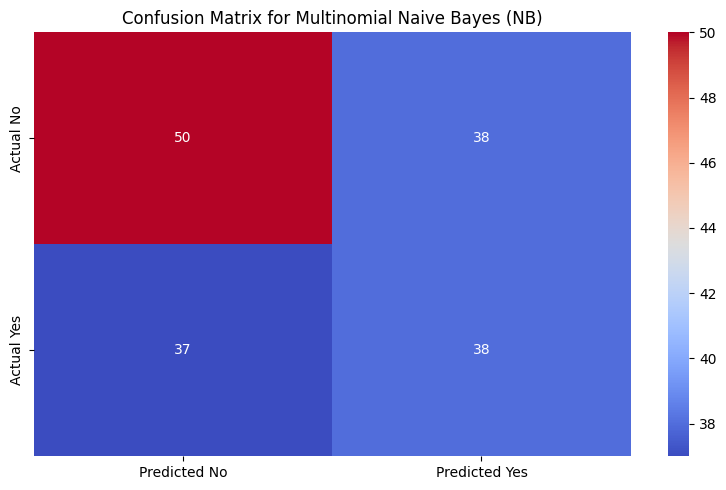

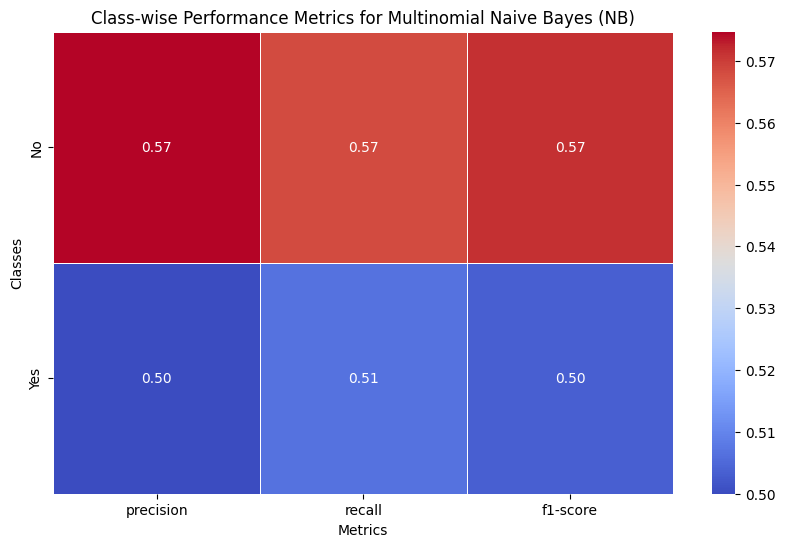

In [83]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Model Output
# Classification report
MNB_classification_report=classification_report(y_test, MNB_y_test_pred)
print(MNB_classification_report)


# Confusion matrix with seaborn heatmap
MNB_conf_matrix=confusion_matrix(y_test, MNB_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(MNB_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Multinomial Naive Bayes (NB)')
plt.tight_layout()
plt.savefig("MNB_confusion_matrix.png")


# Class-wise Performance Metrics
MNB_classification_report_2 = classification_report(y_test, MNB_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
MNB_class_metrics = {metric: [MNB_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(MNB_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Multinomial Naive Bayes (NB)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("MNB_performance_metrics.png")
plt.show()

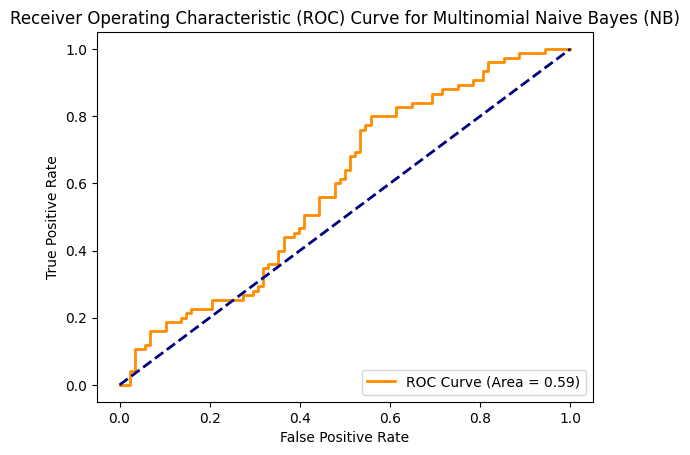

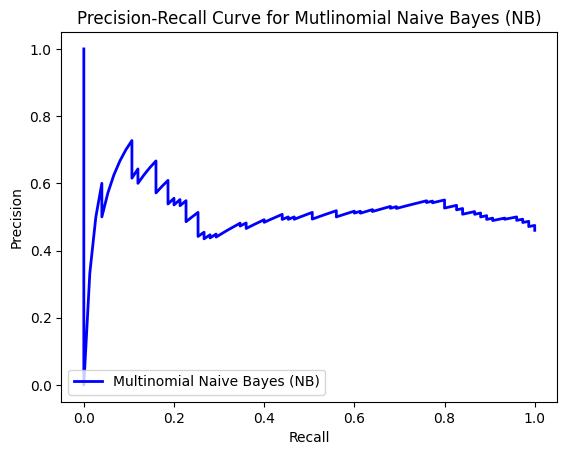

In [88]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
MNB_y_scores=MNB_pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, MNB_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multinomial Naive Bayes (NB)')
plt.legend(loc="lower right")
plt.savefig("MNB_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, MNB_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Multinomial Naive Bayes (NB)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Mutlinomial Naive Bayes (NB)')
plt.legend(loc="lower left")
plt.savefig("MNB_precision_recall_curve.png")
plt.show()

#### 1.3 Support Vector Machine (SVM)

In [89]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [90]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [92]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=42)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5, random_state=42)

In [93]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


#### 1.3.1 Initialize and training the model

In [94]:
# Model 3: Support Vector Machine Classifier (SVM) (<5s)

# init and training the model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize and train the model with L1 regularization (Lasso)
SVC = SVC(probability=True, random_state=42)  # C is the inverse of regularization strength
SVC.fit(X_train, y_train)

# Predict on the train set
SVC_y_train_pred = SVC.predict(X_train)

# Evaluate the model
SVC_train_accuracy_pretuned = accuracy_score(y_train, SVC_y_train_pred)
print("Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: {}".format(SVC_train_accuracy_pretuned))

Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: 0.5354938271604939


#### 1.3.2 Model Hyperparamter Tuning

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the pipeline with SVC
SVC_pipeline = Pipeline([
    ('classifier', SVC(probability=True, random_state=42))  # Support Vector Classification
])

# Define parameter grid for GridSearchCV
SVC_pipeline_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    # 'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'classifier__degree': [2, 3, 4],  # Degree of the polynomial kernel function (if 'poly')
    'classifier__probability': [True]
}

# Perform Grid Search CV
SVC_grid_search = GridSearchCV(SVC_pipeline, SVC_pipeline_param_grid, cv=5, verbose=1)
SVC_grid_search.fit(X_val, y_val)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__kernel': ['linear', 'rbf', 'poly',
                                                'sigmoid'],
                         'classifier__probability': [True]},
             verbose=1)

In [96]:
# Retrieve the best estimator after Grid Search CV is fitted
best_SVC_estimator = SVC_grid_search.best_estimator_

SVC_val_accuracy = SVC_grid_search.best_score_
print("Validation accuracy from Randomized Search CV: {}".format(SVC_val_accuracy))
print("The best set of parameters of SVC is: ", best_SVC_estimator)

Validation accuracy from Randomized Search CV: 0.5681818181818181
The best set of parameters of SVC is:  Pipeline(steps=[('classifier',
                 SVC(C=1, kernel='linear', probability=True, random_state=42))])


##### 1.3.3 Model Saving/ Loading

In [97]:
# Save tuned model and its best hyperparameters
import joblib

joblib.dump(SVC_grid_search.best_estimator_, 'SVC_model.pkl')
joblib.dump(SVC_grid_search.best_params_,'SVC_best_params.joblib')

['SVC_best_params.joblib']

In [98]:
# # load the saved model (NOTE: uncomment only if needed)
# import joblib

# loaded_model=joblib.load('SVC_model.pkl')
# loaded_model_best_params=joblib.load('SVC_best_params.joblib')

##### 1.3.4 Model Predictions

In [99]:
# Refit the model with the best parameters
SVC_pipeline.set_params(**SVC_grid_search.best_params_,)
SVC_pipeline.fit(X_train, y_train)

# Make predictions on the training set and calculate accuracy
SVC_y_train_pred_tuned = SVC_pipeline.predict(X_train)
SVC_train_accuracy_posttuned = accuracy_score(y_train, SVC_y_train_pred_tuned)
print("Training accuracy after tuning: {}".format(SVC_train_accuracy_posttuned))

# Make predictions on the test set and calculate accuracy
SVC_y_test_pred = SVC_pipeline.predict(X_test)
SVC_test_accuracy = accuracy_score(y_test, SVC_y_test_pred)
print("Testing (Post-tuned) Accuracy from automated tuning on LR: {}".format(SVC_test_accuracy))

Training accuracy after tuning: 0.5532407407407407
Testing (Post-tuned) Accuracy from automated tuning on LR: 0.6196319018404908


##### 1.3.5 Results Visualization

In [100]:
# Accuracy Comaprsion

print("Classification Accuracies for Multinomial Naive Bayes (NB):")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(SVC_train_accuracy_pretuned*100, SVC_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(SVC_train_accuracy_posttuned*100, SVC_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(SVC_val_accuracy*100, SVC_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(SVC_test_accuracy*100, SVC_test_accuracy))

Classification Accuracies for Multinomial Naive Bayes (NB):
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		53.55% 	(0.5354938271604939)
Training Accuracy (Post-tuned): 	55.32% 	(0.5532407407407407)

Validation Accuracy: 			56.82% 	(0.5681818181818181)
Testing Accuracy: 			61.96% 	(0.6196319018404908)


              precision    recall  f1-score   support

           0       0.60      0.85      0.71        88
           1       0.67      0.35      0.46        75

    accuracy                           0.62       163
   macro avg       0.64      0.60      0.58       163
weighted avg       0.63      0.62      0.59       163



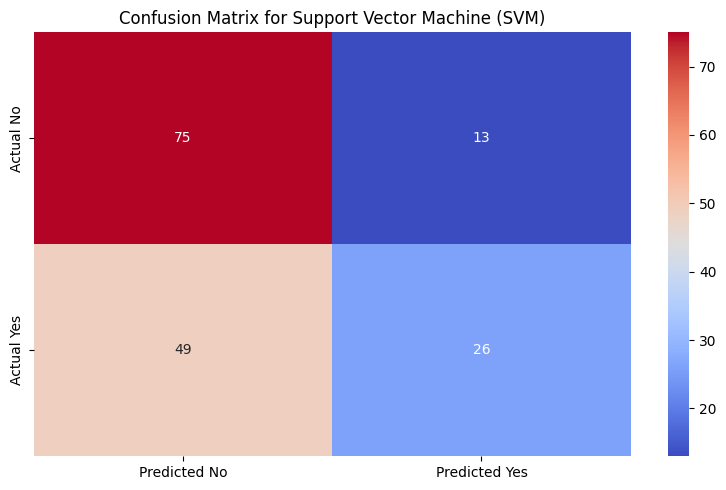

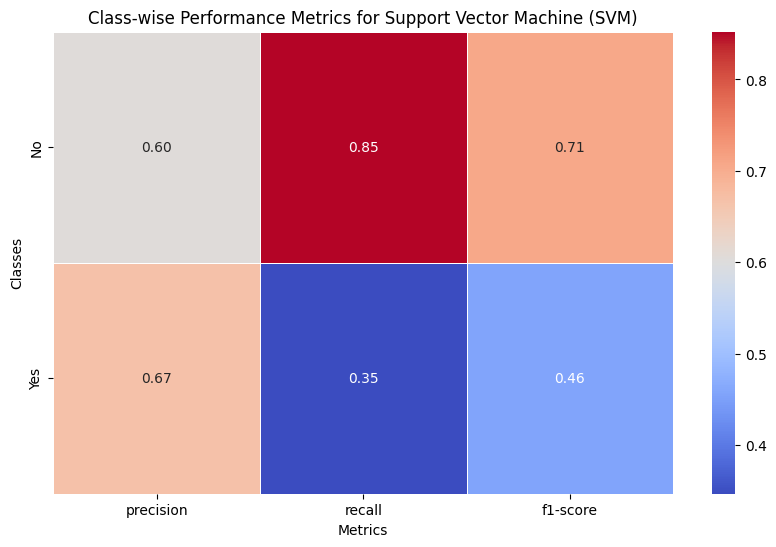

In [101]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Model Output
# Classification report
SVC_classification_report=classification_report(y_test, SVC_y_test_pred)
print(SVC_classification_report)


# Confusion matrix with seaborn heatmap
SVC_conf_matrix=confusion_matrix(y_test, SVC_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(SVC_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Support Vector Machine (SVM)')
plt.tight_layout()
plt.savefig("SVC_confusion_matrix.png")


# Class-wise Performance Metrics
SVC_classification_report_2 = classification_report(y_test, SVC_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
SVC_class_metrics = {metric: [SVC_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(SVC_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Support Vector Machine (SVM)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("SVC_performance_metrics.png")
plt.show()

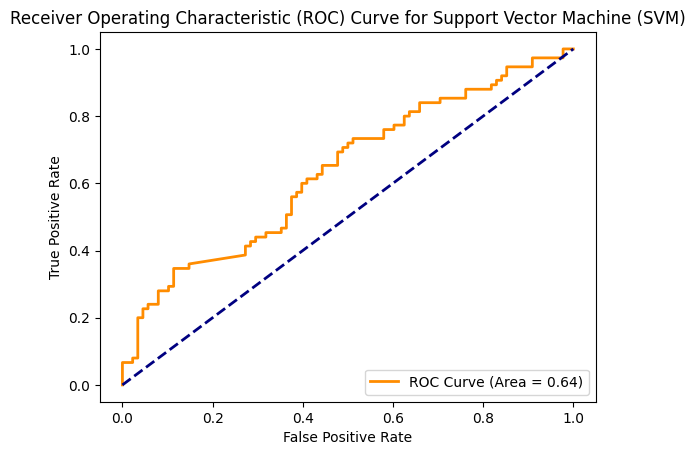

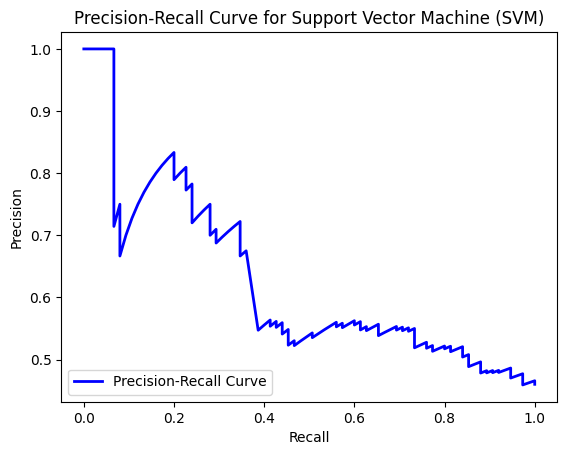

In [102]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
SVC_y_scores=SVC_pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, SVC_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Support Vector Machine (SVM)')
plt.legend(loc="lower right")
plt.savefig("SVC_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, SVC_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Support Vector Machine (SVM)')
plt.legend(loc="lower left")
plt.savefig("SVC_precision_recall_curve.png")
plt.show()

#### 1.4 Feedforward Neural Network (FNN)

In [50]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [51]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [53]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2, random_state=42)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5, random_state=42)

In [54]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


#### 1.4.1 Initialize and training the model

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential # FNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam # ADAM optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # add stoppoint 
from sklearn.model_selection import train_test_split, KFold 
from sklearn.metrics import accuracy_score

# Define Feedforward Neural Network model
def create_model(learning_rate=0.001):
    # Define FNN
    model = Sequential()
    # add layers
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # init optimizer
    optimizer = Adam(learning_rate=learning_rate)
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Setting early Stopping and Model Checkpointing Callbacks
FNN_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
FNN_model_checkpoint = ModelCheckpoint('best_FNN_model.keras', monitor='val_loss', save_best_only=True)

# Train the initial model (pre-tuning)
FNN_model = create_model()
# 50 epochs, 32 batch size, declare validation data and callback
history_fnn = FNN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), 
                                callbacks=[FNN_early_stopping, FNN_model_checkpoint], verbose=1)

# Predict and evaluate pre-tuning model
FNN_y_train_pred = (FNN_model.predict(X_train) > 0.5).astype("int32")
FNN_train_accuracy_pretuned = accuracy_score(y_train, FNN_y_train_pred)
print(f"Feedforward Neural Network Training Accuracy (Pre-tuned): {FNN_train_accuracy_pretuned:.2f}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5408 - loss: 100.0630 - val_accuracy: 0.4630 - val_loss: 35.2705
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4972 - loss: 35.0743 - val_accuracy: 0.4630 - val_loss: 1.6518
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4791 - loss: 82.2169 - val_accuracy: 0.4630 - val_loss: 37.6891
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5130 - loss: 29.0586 - val_accuracy: 0.4630 - val_loss: 58.4740
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5038 - loss: 24.9927 - val_accuracy: 0.4630 - val_loss: 92.7653
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4879 - loss: 66.7678 - val_accuracy: 0.5370 - val_loss: 24.1874
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5193 - loss: 48.1947 - val_accuracy: 0.4630 - val_loss: 19.1112
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4952 - loss: 26.9284 - val_accuracy:

#### 1.4.2 Model Hyperparamter Tuning + Model Saving

In [56]:
# Define hyperparameter grid for manual cross-validation
FNN_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Manual cross-validation and hyperparameter tuning
FNN_best_val_accuracy = 0
FNN_best_params = None

# iterate over each parameter
for lr in FNN_param_grid['learning_rate']:
    for epochs in FNN_param_grid['epochs']:
        for batch_size in FNN_param_grid['batch_size']:
            print(f"Training with learning_rate={lr}, epochs={epochs}, batch_size={batch_size}")
            
            # Create and compile the model with current parameters
            model = create_model(learning_rate=lr)
            
            # Train the model based on each parameter
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val, y_val), callbacks=[FNN_early_stopping], verbose=0)
            
            # Evaluate on validation data
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Accuracy: {val_accuracy:.2f}")
            
            # Save the best model
            if val_accuracy > FNN_best_val_accuracy:
                FNN_best_val_accuracy = val_accuracy
                FNN_best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
                model.save('best_FNN_model.keras')

# print the best parameters out
print()
print(f"Best validation accuracy: {FNN_best_val_accuracy}")
print(f"Best Parameters: {FNN_best_params}")

Training with learning_rate=0.001, epochs=50, batch_size=32


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=100, batch_size=64
Validation Accuracy: 0.46
Training with learning_rate=0.01, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=64
Validation Accuracy: 0.46
Training with learning_rate=0.1, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=100, batch_size=64
Validation Accuracy: 0.54

Best validation accuracy: 0.53703

#### 1.4.3 Model Loading and Predcitions

In [57]:
# Load the best model saved during training
from tensorflow.keras.models import load_model
FNN_best_model = load_model('best_FNN_model.keras')

# Evaluate post-tuning model on training data
FNN_y_train_pred_tuned = (FNN_best_model.predict(X_train) > 0.5).astype("int32")
FNN_train_accuracy_posttuned = accuracy_score(y_train, FNN_y_train_pred_tuned)
print(f"Feedforward Neural Network Training Accuracy (Post-tuned): {FNN_train_accuracy_posttuned:.2f}")

# Evaluate post-tuning model on test data
FNN_y_test_pred = (FNN_best_model.predict(X_test) > 0.5).astype("int32")
FNN_test_accuracy = accuracy_score(y_test, FNN_y_test_pred)
print(f"Feedforward Neural Network Testing Accuracy: {FNN_test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Feedforward Neural Network Training Accuracy (Post-tuned): 0.54
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Feedforward Neural Network Testing Accuracy: 0.54


##### 1.4.4 Results Visualization

In [58]:
# Accuracy Comaprsion

print("Classification Accuracies for Feedforward Neural Network (FNN):")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(FNN_train_accuracy_pretuned*100, FNN_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(FNN_train_accuracy_posttuned*100, FNN_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(FNN_best_val_accuracy*100, FNN_best_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(FNN_test_accuracy*100, FNN_test_accuracy))

Classification Accuracies for Feedforward Neural Network (FNN):
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		51.85% 	(0.5185185185185185)
Training Accuracy (Post-tuned): 	53.55% 	(0.5354938271604939)

Validation Accuracy: 			53.70% 	(0.5370370149612427)
Testing Accuracy: 			53.99% 	(0.5398773006134969)


In [59]:
# # Visualization and results
# import matplotlib.pyplot as plt

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history_fnn.history['accuracy'])
# plt.plot(history_fnn.history['val_accuracy'])
# plt.title('Model accuracy (Pre-tuned)')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history_fnn.history['loss'])
# plt.plot(history_fnn.history['val_loss'])
# plt.title('Model loss (Pre-tuned)')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
# plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        88
           1       0.00      0.00      0.00        75

    accuracy                           0.54       163
   macro avg       0.27      0.50      0.35       163
weighted avg       0.29      0.54      0.38       163



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

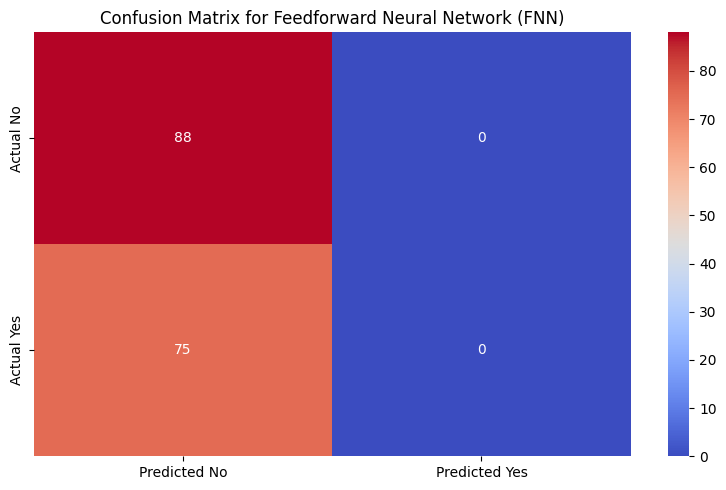

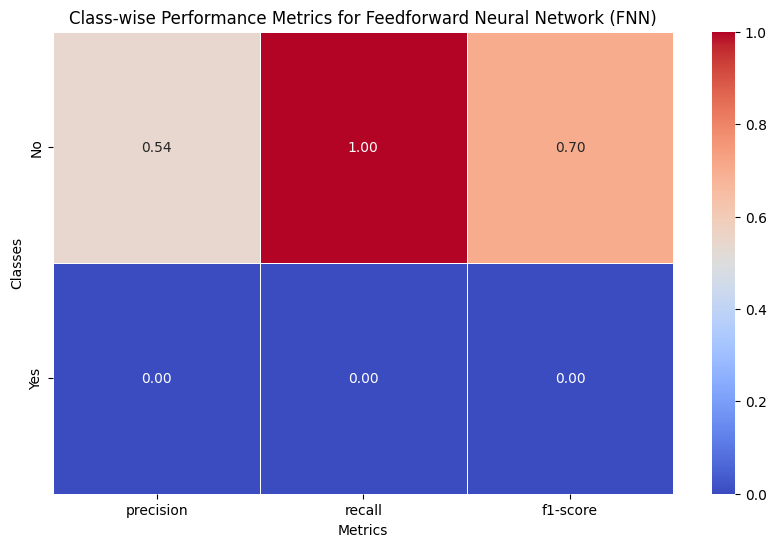

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
FNN_classification_report=classification_report(y_test, FNN_y_test_pred)
print(FNN_classification_report)

# Confusion matrix with seaborn heatmap
FNN_conf_matrix=confusion_matrix(y_test, FNN_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(FNN_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Feedforward Neural Network (FNN)')
plt.tight_layout()
plt.savefig("FNN_confusion_matrix.png")


# Class-wise Performance Metrics
FNN_classification_report_2 = classification_report(y_test, FNN_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
FNN_class_metrics = {metric: [FNN_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(FNN_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Feedforward Neural Network (FNN)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("FNN_performance_metrics.png")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


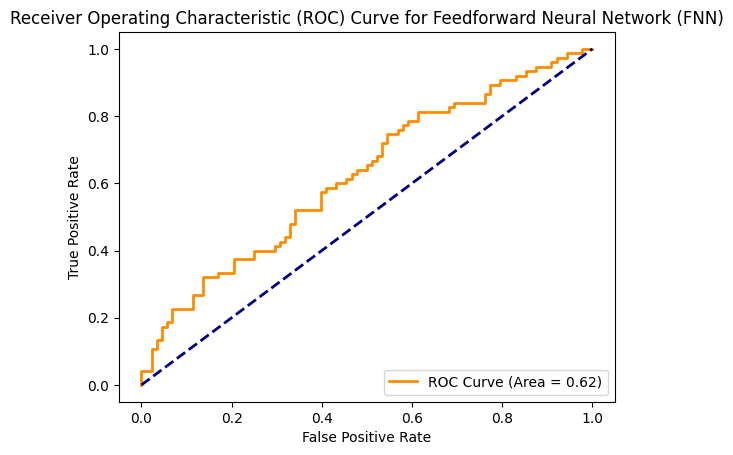

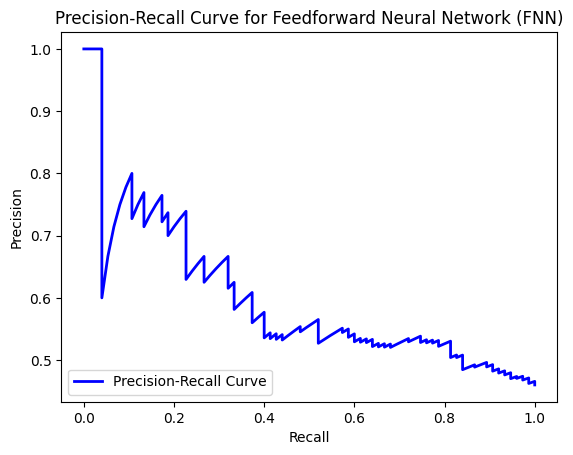

In [61]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
# FNN_y_scores=FNN_best_model.predict_proba(X_test)[:, 1]
FNN_y_scores=FNN_best_model.predict(X_test)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, FNN_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Feedforward Neural Network (FNN)')
plt.legend(loc="lower right")
plt.savefig("FNN_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, FNN_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Feedforward Neural Network (FNN)')
plt.legend(loc="lower left")
plt.savefig("FNN_precision_recall_curve.png")
plt.show()

#### 1.5 Convolutional Neural Network

In [74]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [75]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:].values

In [77]:
# Reshape for CNN input
x = x.reshape(x.shape[0], x.shape[1], 1)

In [78]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [79]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097, 1)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097, 1)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097, 1)
Y:  (163,)


In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define CNN model
def create_cnn_model(learning_rate=0.001):
    # Declare sequential layer
    model = Sequential()
    # Add first 1D convolutional layer
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    # Adds a max pooling layer with a pool size of 2 to reduce dimensionality
    model.add(MaxPooling1D(pool_size=2))
    # Add second 1D convolutional layer
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    # Adds another max pooling layer
    model.add(MaxPooling1D(pool_size=2))
    # Add a flatten layer to prepare for the dense (fully-connected) layer
    model.add(Flatten())
    # Add first dense layer
    model.add(Dense(64, activation='relu'))
    # Add another dense layer
    model.add(Dense(32, activation='relu'))
    # Add output layer to summarize classification ouput
    model.add(Dense(1, activation='sigmoid'))

    # Init ADAM optimizer
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with cross-entropy loss
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define early stopping and model checkpointing
CNN_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
CNN_model_checkpoint = ModelCheckpoint('best_CNN_model.keras', monitor='val_loss', save_best_only=True)

# Train the initial model (pre-tuning)
# create CNN model and fit it
CNN_model = create_cnn_model()
history_cnn = CNN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), 
                            callbacks=[CNN_early_stopping, CNN_model_checkpoint], verbose=1)

# Predict and evaluate pre-tuning model
CNN_y_train_pred = (CNN_model.predict(X_train) > 0.5).astype("int32")
CNN_train_accuracy_pretuned = accuracy_score(y_train, CNN_y_train_pred)
print(f"Convolutional Neural Network Training Accuracy (Pre-tuned): {CNN_train_accuracy_pretuned:.2f}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 566ms/step - accuracy: 0.5130 - loss: 79.3606 - val_accuracy: 0.5370 - val_loss: 21.7704
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 523ms/step - accuracy: 0.4873 - loss: 8.7147 - val_accuracy: 0.4630 - val_loss: 4.1087
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 539ms/step - accuracy: 0.4976 - loss: 4.3537 - val_accuracy: 0.5370 - val_loss: 1.7920
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 575ms/step - accuracy: 0.5286 - loss: 2.0527 - val_accuracy: 0.5370 - val_loss: 0.8508
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 525ms/step - accuracy: 0.5044 - loss: 0.7750 - val_accuracy: 0.4630 - val_loss: 0.7351
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - accuracy: 0.5302 - loss: 0.7102 - val_accuracy: 0.4568 - val_loss: 1.0382
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 513ms/step - accuracy: 0.5139 - loss: 0.7894 - val_accuracy: 0.5309 - val_loss: 0.7867
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - accuracy: 0.5681 - loss: 0.7220 - val_ac

#### 1.5.2 Model Hyperparamter Tuning + Model Saving

In [81]:
# Define hyperparameter grid for manual cross-validation
CNN_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Manual cross-validation and hyperparameter tuning
CNN_best_val_accuracy = 0
CNN_best_params = None

# Loop through each parameter, then determine the validation accuracy from each combination of parameters
# Keep the best combination of parameters with the best validation accuracy
for lr in CNN_param_grid['learning_rate']:
    for epochs in CNN_param_grid['epochs']:
        for batch_size in CNN_param_grid['batch_size']:
            print(f"Training with learning_rate={lr}, epochs={epochs}, batch_size={batch_size}")
            model = create_cnn_model(learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val, y_val), callbacks=[CNN_early_stopping], verbose=0)
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Accuracy: {val_accuracy:.2f}")
            if val_accuracy > CNN_best_val_accuracy:
                CNN_best_val_accuracy = val_accuracy
                CNN_best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
                model.save('best_CNN_model.keras')

# Print output
print(f"Best validation accuracy: {CNN_best_val_accuracy}")
print(f"Best Parameters: {CNN_best_params}")

Training with learning_rate=0.001, epochs=50, batch_size=32


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=100, batch_size=32
Validation Accuracy: 0.46
Training with learning_rate=0.001, epochs=100, batch_size=64
Validation Accuracy: 0.46
Training with learning_rate=0.01, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=64
Validation Accuracy: 0.46
Training with learning_rate=0.1, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=50, batch_size=64
Validation Accuracy: 0.46
Training with learning_rate=0.1, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=100, batch_size=64
Validation Accuracy: 0.54
Best validation accuracy: 0.537037

#### 1.5.3 Model Loading and Predcitions

In [82]:
# Load the best model saved during training
CNN_best_model = tf.keras.models.load_model('best_CNN_model.keras')

# Evaluate post-tuning model on training data
CNN_y_train_pred_tuned = (CNN_best_model.predict(X_train) > 0.5).astype("int32")
CNN_train_accuracy_posttuned = accuracy_score(y_train, CNN_y_train_pred_tuned)
print(f"Convolutional Neural Network Training Accuracy (Post-tuned): {CNN_train_accuracy_posttuned:.2f}")

# Evaluate post-tuning model on test data
CNN_y_test_pred = (CNN_best_model.predict(X_test) > 0.5).astype("int32")
CNN_test_accuracy = accuracy_score(y_test, CNN_y_test_pred)
print(f"Convolutional Neural Network Testing Accuracy: {CNN_test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


Convolutional Neural Network Training Accuracy (Post-tuned): 0.54
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
Convolutional Neural Network Testing Accuracy: 0.54


##### 1.5.4 Results Visualization

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        88
           1       0.00      0.00      0.00        75

    accuracy                           0.54       163
   macro avg       0.27      0.50      0.35       163
weighted avg       0.29      0.54      0.38       163



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

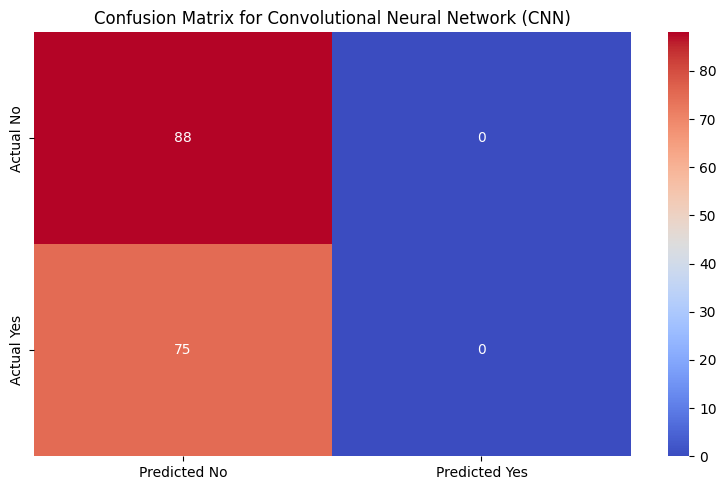

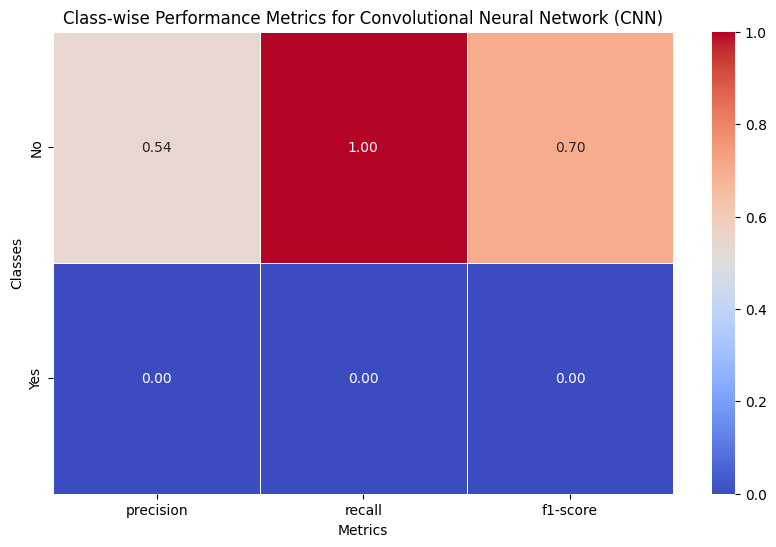

In [83]:
# Classification report
CNN_classification_report = classification_report(y_test, CNN_y_test_pred)
print(CNN_classification_report)

# Confusion matrix with seaborn heatmap
CNN_conf_matrix = confusion_matrix(y_test, CNN_y_test_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(CNN_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Convolutional Neural Network (CNN)')
plt.tight_layout()
plt.savefig("CNN_confusion_matrix.png")

# Class-wise Performance Metrics
CNN_classification_report_2 = classification_report(y_test, CNN_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
CNN_class_metrics = {metric: [CNN_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap to display class-wise Performance Metrics
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(CNN_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Convolutional Neural Network (CNN)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("CNN_performance_metrics.png")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


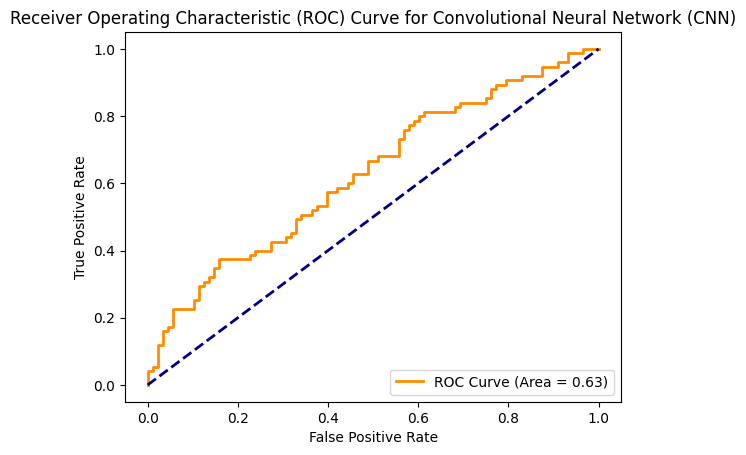

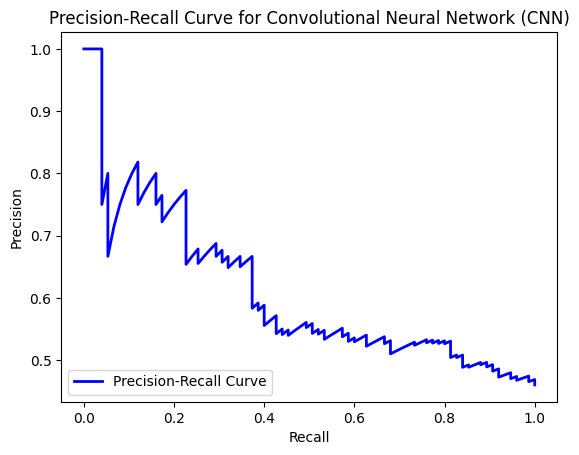

In [84]:
# ROC Curve
CNN_y_scores = CNN_best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, CNN_y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Convolutional Neural Network (CNN)')
plt.legend(loc="lower right")
plt.savefig("CNN_roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, CNN_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Convolutional Neural Network (CNN)')
plt.legend(loc="lower left")
plt.savefig("CNN_precision_recall_curve.png")
plt.show()

In [ ]:
# Backup

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 574ms/step - accuracy: 0.5242 - loss: 58.0789 - val_accuracy: 0.5370 - val_loss: 20.7840
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.5081 - loss: 6.9118 - val_accuracy: 0.4630 - val_loss: 4.1373
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 526ms/step - accuracy: 0.4852 - loss: 3.0870 - val_accuracy: 0.4630 - val_loss: 0.8202
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 525ms/step - accuracy: 0.5024 - loss: 2.5958 - val_accuracy: 0.5370 - val_loss: 1.0420
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step - accuracy: 0.5572 - loss: 0.8263 - val_accuracy: 0.5309 - val_loss: 0.7319
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 548ms/step - accuracy: 0.5211 - loss: 0.7840 - val_accuracy: 0.4815 - val_loss: 0.7213
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 539ms/step - accuracy: 0.5081 - loss: 0.8089 - val_accuracy: 0.5432 - val_loss: 0.6932
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 546ms/step - accuracy: 0.5408 - loss: 0.8342 - val_ac

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=100, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=100, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=100, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.1, epochs=100, batch_size=64
Validation Accuracy: 0.54
Best validation accuracy: 0.537037

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

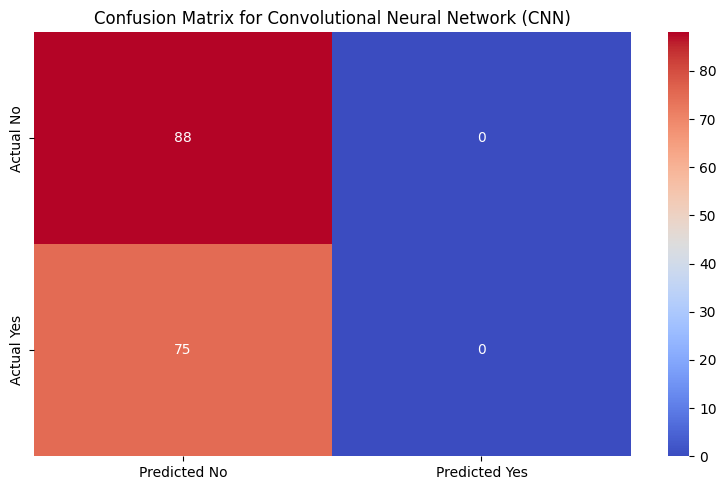

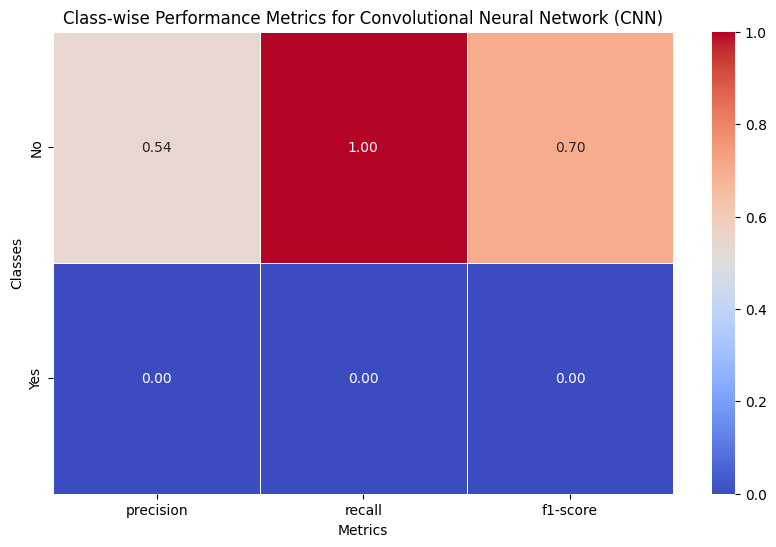

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


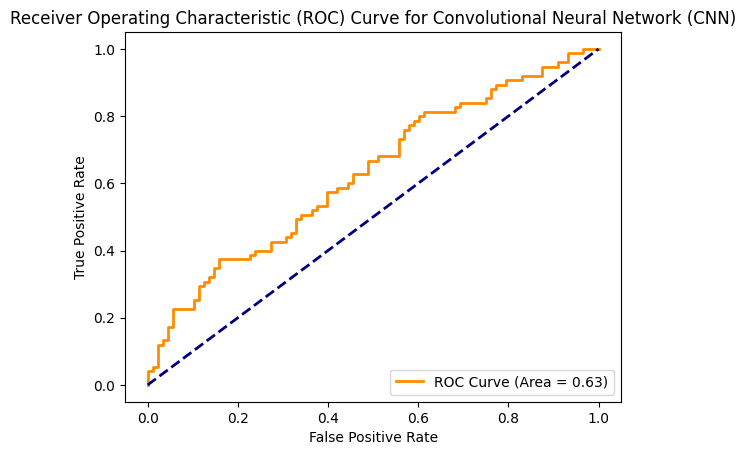

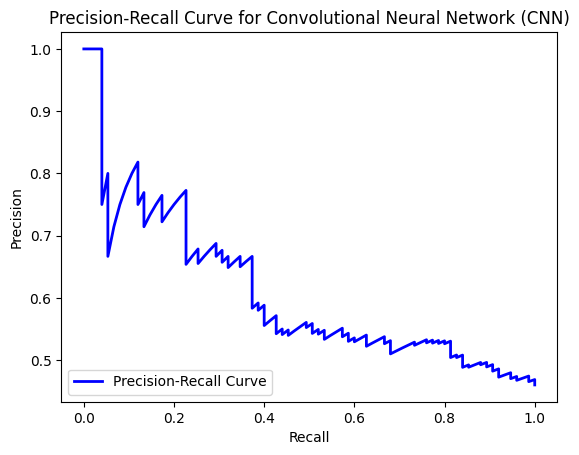

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

# Assign target variable
y = df.loc[:, df.columns == 'mood'].values.ravel()

# Drop unnecessary columns
df.drop(['valence', 'mood', 'lyrics'], axis=1, inplace=True)

# Feature variables
x = df.iloc[:, 4:].values

# Reshape for CNN input
x = x.reshape(x.shape[0], x.shape[1], 1)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define CNN model
def create_cnn_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping and model checkpointing
CNN_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
CNN_model_checkpoint = ModelCheckpoint('best_CNN_model.keras', monitor='val_loss', save_best_only=True)

# Train the initial model (pre-tuning)
CNN_model = create_cnn_model()
history_cnn = CNN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), 
                            callbacks=[CNN_early_stopping, CNN_model_checkpoint], verbose=1)

# Predict and evaluate pre-tuning model
CNN_y_train_pred = (CNN_model.predict(X_train) > 0.5).astype("int32")
CNN_train_accuracy_pretuned = accuracy_score(y_train, CNN_y_train_pred)
print(f"Convolutional Neural Network Training Accuracy (Pre-tuned): {CNN_train_accuracy_pretuned:.2f}")

# Define hyperparameter grid for manual cross-validation
CNN_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Manual cross-validation and hyperparameter tuning
CNN_best_val_accuracy = 0
CNN_best_params = None

for lr in CNN_param_grid['learning_rate']:
    for epochs in CNN_param_grid['epochs']:
        for batch_size in CNN_param_grid['batch_size']:
            print(f"Training with learning_rate={lr}, epochs={epochs}, batch_size={batch_size}")
            model = create_cnn_model(learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val, y_val), callbacks=[CNN_early_stopping], verbose=0)
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Accuracy: {val_accuracy:.2f}")
            if val_accuracy > CNN_best_val_accuracy:
                CNN_best_val_accuracy = val_accuracy
                CNN_best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
                model.save('best_CNN_model.keras')

print(f"Best validation accuracy: {CNN_best_val_accuracy}")
print(f"Best Parameters: {CNN_best_params}")

# Load the best model saved during training
CNN_best_model = tf.keras.models.load_model('best_CNN_model.keras')

# Evaluate post-tuning model on training data
CNN_y_train_pred_tuned = (CNN_best_model.predict(X_train) > 0.5).astype("int32")
CNN_train_accuracy_posttuned = accuracy_score(y_train, CNN_y_train_pred_tuned)
print(f"Convolutional Neural Network Training Accuracy (Post-tuned): {CNN_train_accuracy_posttuned:.2f}")

# Evaluate post-tuning model on test data
CNN_y_test_pred = (CNN_best_model.predict(X_test) > 0.5).astype("int32")
CNN_test_accuracy = accuracy_score(y_test, CNN_y_test_pred)
print(f"Convolutional Neural Network Testing Accuracy: {CNN_test_accuracy:.2f}")

# Classification report
CNN_classification_report = classification_report(y_test, CNN_y_test_pred)
print(CNN_classification_report)

# Confusion matrix with seaborn heatmap
CNN_conf_matrix = confusion_matrix(y_test, CNN_y_test_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(CNN_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Convolutional Neural Network (CNN)')
plt.tight_layout()
plt.savefig("CNN_confusion_matrix.png")

# Class-wise Performance Metrics
CNN_classification_report_2 = classification_report(y_test, CNN_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
CNN_class_metrics = {metric: [CNN_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(CNN_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Convolutional Neural Network (CNN)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("CNN_performance_metrics.png")
plt.show()

# ROC Curve
CNN_y_scores = CNN_best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, CNN_y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Convolutional Neural Network (CNN)')
plt.legend(loc="lower right")
plt.savefig("CNN_roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, CNN_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Convolutional Neural Network (CNN)')
plt.legend(loc="lower left")
plt.savefig("CNN_precision_recall_curve.png")
plt.show()


# RNN

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

# Assign target variable
y = df.loc[:, df.columns == 'mood'].values.ravel()

# Drop unnecessary columns
df.drop(['valence', 'mood', 'lyrics'], axis=1, inplace=True)

# Feature variables
x = df.iloc[:, 4:].values

# Normalize the data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Reshape for RNN input
x = x.reshape(x.shape[0], x.shape[1], 1)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [7]:
# Define RNN model
def create_rnn_model(learning_rate=0.001):
    # sequential layer
    model = Sequential()
    # add LSTM (long short-term memory)
    model.add(LSTM(20, activation='relu', input_shape=(X_train.shape[1], 1)))
    # add 2 dense layers
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # ADAM optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping and model checkpointing
model_checkpoint_path = 'best_RNN_model.keras'
RNN_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RNN_model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the initial model (pre-tuning)
RNN_model = create_rnn_model()
history_rnn = RNN_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), 
                            callbacks=[RNN_early_stopping, RNN_model_checkpoint], verbose=1)

# Predict and evaluate pre-tuning model
RNN_y_train_pred = (RNN_model.predict(X_train) > 0.5).astype("int32")
RNN_train_accuracy_pretuned = accuracy_score(y_train, RNN_y_train_pred)
print(f"Recurrent Neural Network Training Accuracy (Pre-tuned): {RNN_train_accuracy_pretuned:.2f}")

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5287 - loss: 0.6927 - val_accuracy: 0.5370 - val_loss: 0.6894
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5409 - loss: 0.6912 - val_accuracy: 0.5370 - val_loss: 0.6876
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5383 - loss: 0.6905 - val_accuracy: 0.5370 - val_loss: 0.6882
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5168 - loss: 0.6921 - val_accuracy: 0.5370 - val_loss: 0.6876
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5410 - loss: 0.6900 - val_accuracy: 0.5370 - val_loss: 0.6875
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.5334 - loss: 0.6906 - val_accuracy: 0.5370 - val_loss: 0.6871
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5248 - loss: 0.6912 - val_accuracy: 0.5370 - val_loss: 0.6871
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5257 - loss: 0.6916 - val_accuracy: 0.5370 - val_loss:

In [8]:
# Hyperparameter tuning (simplified)
RNN_param_grid = {
    'learning_rate': [0.001, 0.01],
    'epochs': [30, 50],
    'batch_size': [32, 64]
}

RNN_best_val_accuracy = 0
RNN_best_params = None

for lr in RNN_param_grid['learning_rate']:
    for epochs in RNN_param_grid['epochs']:
        for batch_size in RNN_param_grid['batch_size']:
            print(f"Training with learning_rate={lr}, epochs={epochs}, batch_size={batch_size}")
            model = create_rnn_model(learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val, y_val), callbacks=[RNN_early_stopping], verbose=0)
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Accuracy: {val_accuracy:.2f}")
            if val_accuracy > RNN_best_val_accuracy:
                RNN_best_val_accuracy = val_accuracy
                RNN_best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
                model.save(model_checkpoint_path)

print(f"Best validation accuracy: {RNN_best_val_accuracy}")
print(f"Best Parameters: {RNN_best_params}")

Training with learning_rate=0.001, epochs=30, batch_size=32


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=30, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=64
Validation Accuracy: 0.52
Training with learning_rate=0.01, epochs=30, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=30, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=64
Validation Accuracy: 0.54
Best validation accuracy: 0.5370370149612427
Best Parameters: {'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}


In [9]:

# Load the best model saved during training
RNN_best_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate post-tuning model on training data
RNN_y_train_pred_tuned = (RNN_best_model.predict(X_train) > 0.5).astype("int32")
RNN_train_accuracy_posttuned = accuracy_score(y_train, RNN_y_train_pred_tuned)
print(f"Recurrent Neural Network Training Accuracy (Post-tuned): {RNN_train_accuracy_posttuned:.2f}")

# Evaluate post-tuning model on test data
RNN_y_test_pred = (RNN_best_model.predict(X_test) > 0.5).astype("int32")
RNN_test_accuracy = accuracy_score(y_test, RNN_y_test_pred)
print(f"Recurrent Neural Network Testing Accuracy: {RNN_test_accuracy:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 776ms/step
Recurrent Neural Network Training Accuracy (Post-tuned): 0.54
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step
Recurrent Neural Network Testing Accuracy: 0.54


              precision    recall  f1-score   support

           0       0.54      1.00      0.70        88
           1       0.00      0.00      0.00        75

    accuracy                           0.54       163
   macro avg       0.27      0.50      0.35       163
weighted avg       0.29      0.54      0.38       163



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

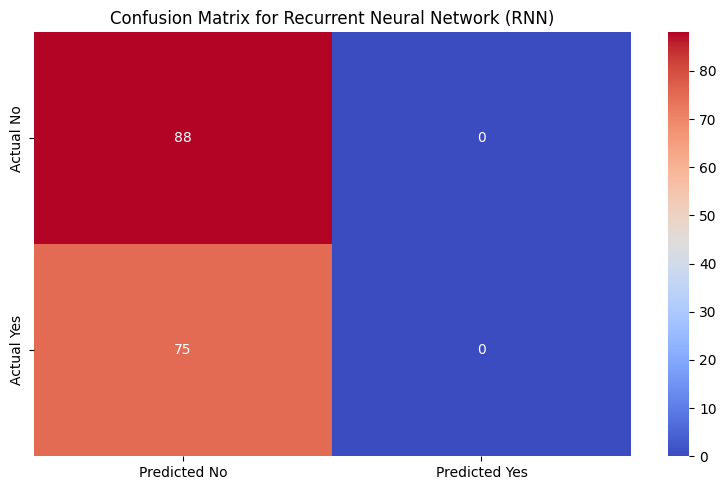

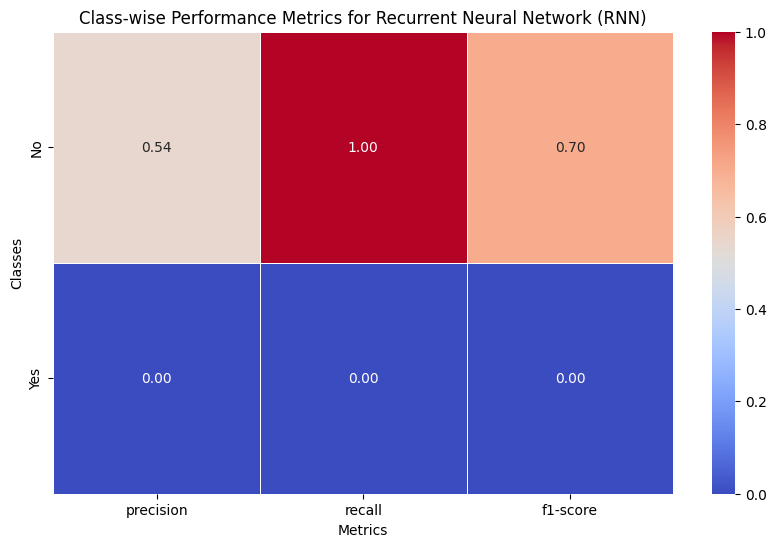

In [10]:
# Classification report
RNN_classification_report = classification_report(y_test, RNN_y_test_pred)
print(RNN_classification_report)

# Confusion matrix with seaborn heatmap
RNN_conf_matrix = confusion_matrix(y_test, RNN_y_test_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(RNN_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Recurrent Neural Network (RNN)')
plt.tight_layout()
plt.savefig("RNN_confusion_matrix.png")

# Class-wise Performance Metrics
RNN_classification_report_2 = classification_report(y_test, RNN_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
RNN_class_metrics = {metric: [RNN_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(RNN_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Recurrent Neural Network (RNN)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("RNN_performance_metrics.png")
plt.show() 

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step


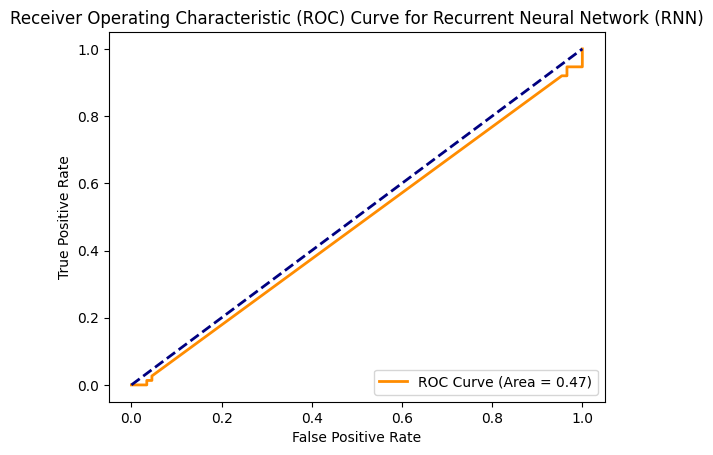

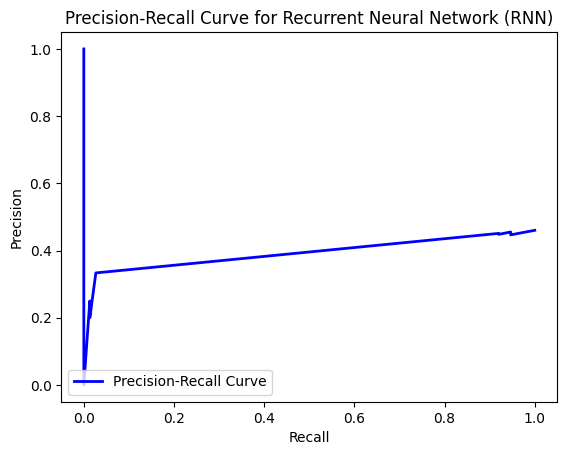

In [11]:
# ROC Curve
RNN_y_scores = RNN_best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, RNN_y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Recurrent Neural Network (RNN)')
plt.legend(loc="lower right")
plt.savefig("RNN_roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, RNN_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Recurrent Neural Network (RNN)')
plt.legend(loc="lower left")
plt.savefig("RNN_precision_recall_curve.png")
plt.show()

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5291 - loss: 0.6924 - val_accuracy: 0.5370 - val_loss: 0.6921
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5412 - loss: 0.6913 - val_accuracy: 0.5370 - val_loss: 0.6914
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.5399 - loss: 0.6908 - val_accuracy: 0.5370 - val_loss: 0.6904
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5317 - loss: 0.6908 - val_accuracy: 0.5370 - val_loss: 0.6902
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5401 - loss: 0.6893 - val_accuracy: 0.5370 - val_loss: 0.6898
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5258 - loss: 0.6913 - val_accuracy: 0.5370 - val_loss: 0.6897
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5290 - loss: 0.6914 - val_accuracy: 0.5370 - val_loss: 0.6896
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5327 - loss: 0.6904 - val_accuracy: 0.5370 - val_loss: 0.6892
Epo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=30, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.001, epochs=50, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=30, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=30, batch_size=64
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=32
Validation Accuracy: 0.54
Training with learning_rate=0.01, epochs=50, batch_size=64
Validation Accuracy: 0.54
Best validation accuracy: 0.5370370149612427
Best Parameters: {'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step
Recurrent Neural Network Training Accuracy (Post-tuned): 0.54
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 736ms/step
Recurrent Neural Network Testing Accuracy: 0.54
              precision    recall  f1-score   support

           

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

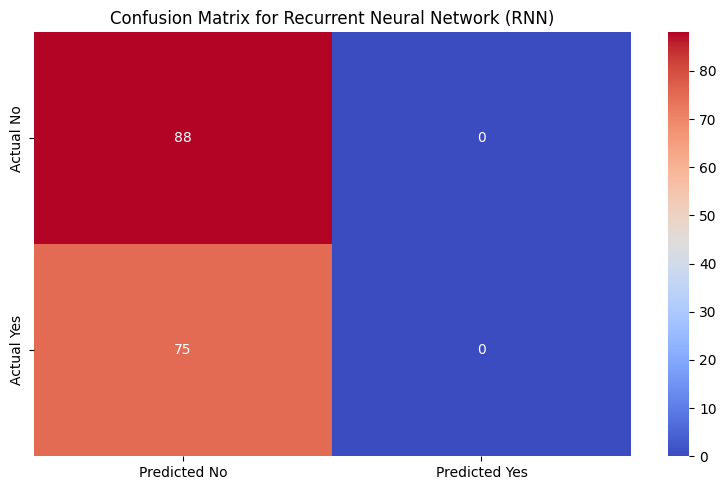

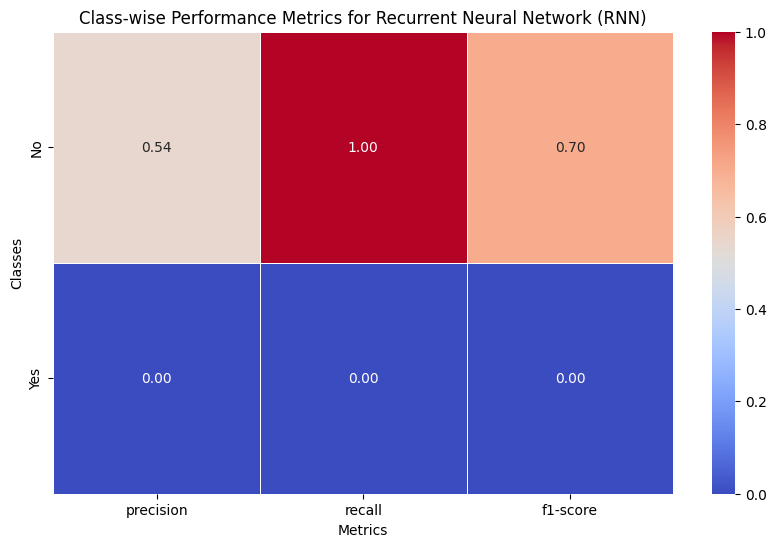

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step


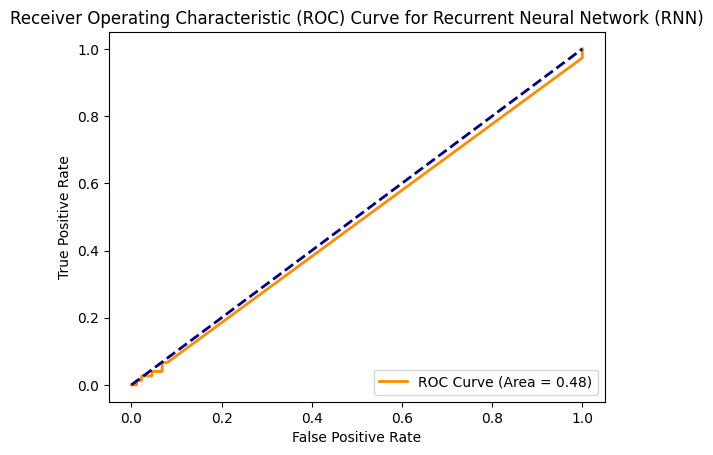

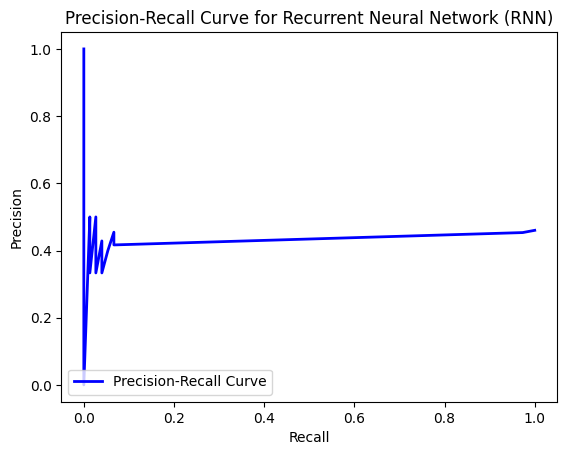

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

# Assign target variable
y = df.loc[:, df.columns == 'mood'].values.ravel()

# Drop unnecessary columns
df.drop(['valence', 'mood', 'lyrics'], axis=1, inplace=True)

# Feature variables
x = df.iloc[:, 4:].values

# Normalize the data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Reshape for RNN input
x = x.reshape(x.shape[0], x.shape[1], 1)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define RNN model
def create_rnn_model(learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(20, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping and model checkpointing
model_checkpoint_path = 'best_rnn_model.keras'
RNN_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RNN_model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the initial model (pre-tuning)
RNN_model = create_rnn_model()
history_rnn = RNN_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), 
                            callbacks=[RNN_early_stopping, RNN_model_checkpoint], verbose=1)

# Predict and evaluate pre-tuning model
RNN_y_train_pred = (RNN_model.predict(X_train) > 0.5).astype("int32")
RNN_train_accuracy_pretuned = accuracy_score(y_train, RNN_y_train_pred)
print(f"Recurrent Neural Network Training Accuracy (Pre-tuned): {RNN_train_accuracy_pretuned:.2f}")

# Hyperparameter tuning (simplified)
RNN_param_grid = {
    'learning_rate': [0.001, 0.01],
    'epochs': [30, 50],
    'batch_size': [32, 64]
}

RNN_best_val_accuracy = 0
RNN_best_params = None

for lr in RNN_param_grid['learning_rate']:
    for epochs in RNN_param_grid['epochs']:
        for batch_size in RNN_param_grid['batch_size']:
            print(f"Training with learning_rate={lr}, epochs={epochs}, batch_size={batch_size}")
            model = create_rnn_model(learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                validation_data=(X_val, y_val), callbacks=[RNN_early_stopping], verbose=0)
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Validation Accuracy: {val_accuracy:.2f}")
            if val_accuracy > RNN_best_val_accuracy:
                RNN_best_val_accuracy = val_accuracy
                RNN_best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}
                model.save(model_checkpoint_path)

print(f"Best validation accuracy: {RNN_best_val_accuracy}")
print(f"Best Parameters: {RNN_best_params}")

# Load the best model saved during training
RNN_best_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate post-tuning model on training data
RNN_y_train_pred_tuned = (RNN_best_model.predict(X_train) > 0.5).astype("int32")
RNN_train_accuracy_posttuned = accuracy_score(y_train, RNN_y_train_pred_tuned)
print(f"Recurrent Neural Network Training Accuracy (Post-tuned): {RNN_train_accuracy_posttuned:.2f}")

# Evaluate post-tuning model on test data
RNN_y_test_pred = (RNN_best_model.predict(X_test) > 0.5).astype("int32")
RNN_test_accuracy = accuracy_score(y_test, RNN_y_test_pred)
print(f"Recurrent Neural Network Testing Accuracy: {RNN_test_accuracy:.2f}")

# Classification report
RNN_classification_report = classification_report(y_test, RNN_y_test_pred)
print(RNN_classification_report)

# Confusion matrix with seaborn heatmap
RNN_conf_matrix = confusion_matrix(y_test, RNN_y_test_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(RNN_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Recurrent Neural Network (RNN)')
plt.tight_layout()
plt.savefig("RNN_confusion_matrix.png")

# Class-wise Performance Metrics
RNN_classification_report_2 = classification_report(y_test, RNN_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
RNN_class_metrics = {metric: [RNN_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(RNN_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Recurrent Neural Network (RNN)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("RNN_performance_metrics.png")
plt.show()

# ROC Curve
RNN_y_scores = RNN_best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, RNN_y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Recurrent Neural Network (RNN)')
plt.legend(loc="lower right")
plt.savefig("RNN_roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, RNN_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Recurrent Neural Network (RNN)')
plt.legend(loc="lower left")
plt.savefig("RNN_precision_recall_curve.png")
plt.show()

## On Combined Feature-Engineered Data